 ## Covariate Shift Analysis

In this notebook, we will take a look at our training data and try to figure out how we might be able to create a set of data that accurately represents the NCAA Tournament games we are trying to predict.

Up to this point, we've collected college basketball data from the last ten to fifteen years which includes individual game scores as well as team statistics over each season. The hope is to use these games as a basis to understand patterns in college basketball games to help us predict winners in NCAA Tournament games. However, we first need to find out if this set of data, which includes both regular season and past tournament games, is actually representative of the games we are trying to predict.

This is where [covariate shift analysis](https://www.analyticsvidhya.com/blog/2017/07/covariate-shift-the-hidden-problem-of-real-world-data-science/) can come in handy. While this technique is often used to understand if data has changed over time, we can use it to determine if the regular season data we've collected is going to be useful for predicting NCAA Tournament games.

In [1]:
# Import packages
import sys
sys.path.append('../../')

import datetime
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import collegebasketball as cbb
cbb.__version__

'0.3'

### Load in the Feature Vectors

To start with we'll load in all of our feature vectors that were generated using other notebooks. Each feature vector represents a single game of college basketball. Features with the suffix `_Fav` indicate a season statistic for the favored team in the given game and other features are for a season statistic for the underdog in that game.

For this analysis, we'll really just be focussing on the data set of feature vectors from each of our input data sources.

In [2]:
# Paths to datasets
path_dir = '../../Data/Feature_Vectors/'

In [3]:
# Load in data
kenpom = pd.read_csv(path_dir + 'kenpom.csv')
tRank = pd.read_csv(path_dir + 'TRank.csv')
stats = pd.read_csv(path_dir + 'stats.csv').drop(['Opp._Fav', 'Opp.', 'Opp._Diff'], axis=1)
all_data = pd.read_csv(path_dir + 'training.csv')
all_data = all_data.assign(Seed_Diff=all_data['Seed_Diff_x']) \
    .drop(['Seed_Diff_x', 'Seed_Diff_y', 'Opp._Fav', 'Opp.', 'Opp._Diff'], axis=1)

# Take a look at the data
kenpom.head(3)

,Favored,Underdog,Year,Tournament,Win_Loss_Fav,Win_Loss,Win_Loss_Diff,Rank_Fav,Rank,Rank_Diff,...,OppD Rank_Fav,OppD Rank,OppD Rank_Diff,NCSOS AdjEM_Fav,NCSOS AdjEM,NCSOS AdjEM_Diff,NCSOS AdjEM Rank_Fav,NCSOS AdjEM Rank,NCSOS AdjEM Rank_Diff,Label
0,Maryland,Arizona,2002,NaN,0.888889,0.705882,0.183007,3,13,-10,...,33,3,30,1.62,17.56,-15.94,120,1,119,1
1,Florida,Arizona,2002,NaN,0.709677,0.705882,0.003795,7,13,-6,...,25,3,22,-0.56,17.56,-18.12,173,1,172,1
2,Arizona,Wyoming,2002,"NCAA, West - Second Round",0.705882,0.709677,-0.003795,13,67,-54,...,3,109,-106,17.56,-5.47,23.03,1,282,-281,0


### Covariate Shift Analysis for Regular Season and NCAA Tournament Data

Now, we'll use the `covariate_shift()` function to help us understand how different our two data sets are. The function will mark each record as either a regular season or tournament game and then will train a random forest classifier to try and predict which data set a given game is from. If the classifier is able to correctly classify a test set of game data, then we know the regular season and tournament data sets are pretty different.

In [4]:
# Function to run covariate shift multiple times and take average for each metric
def cov_shift(train, test, repeat=5):
    metrics = list()
    for _ in range(repeat):
        metrics.append(cbb.covariate_shift(train, test))
    auc = np.mean([x[0] for x in metrics])
    f1 = np.mean([x[1] for x in metrics])
    return auc, f1

In [5]:
# Run the covariate shift function on the data
data = [kenpom, tRank, stats, all_data]
names = ['Kenpom', 'T-Rank', 'Basic Stats', 'All Data']

for df, name in zip(data, names):

    test = cbb.filter_tournament(df)
    train = cbb.filter_tournament(df, drop=True)
    mcc, f1 = cov_shift(train, test)
    print('{0}: auc = {1}, f1 = {2}'.format(name, mcc, f1))

Kenpom: auc = 0.9221926382008195, f1 = 0.9204240870235985
T-Rank: auc = 0.9020477165389782, f1 = 0.9005097991848938
Basic Stats: auc = 0.9148552136886895, f1 = 0.921807201923286
All Data: auc = 0.9018380169217071, f1 = 0.910042089225659


### Which Features have the Most Shift?

In general we can see that the season and tournament data look very different. The random forest classifier was able to easily predict which games were from the regular season and which were from the tournament. This makes intuitive sense because there are tons of regular season games involving teams that would never be good enough to make the tournament.

Next we'll try and zero in on which features show the biggest difference and we will try and use them later on to filter the regular season data to more like tournament data.

In [6]:
df = all_data.copy()
test = cbb.filter_tournament(df)
train = cbb.filter_tournament(df, drop=True)

In [7]:
# Create list of features to test
non_feature_cols = ['Favored', 'Underdog', 'Year', 'Label', 'Tournament',
                    'Seed', 'Seed_Fav', 'Seed_Diff']
feature_to_test = [f for f in df.columns if (f not in non_feature_cols 
                                             and '_Diff' not in f 
                                             and 'Rank' not in f and 'Rk' not in f)]

results = list()
for feature in feature_to_test:
    metrics = list()
    auc, f1 = cov_shift(train[[feature]], test[[feature]])
    results.append((feature, auc, f1))

In [8]:
# Save results in a dataframe and sort by MCC
results_df = pd.DataFrame(results, columns=['Feature', 'AUC', 'F1']).sort_values('AUC', ascending=False)
results_df.head(15)

,Feature,AUC,F1
1,Win_Loss,0.892491,0.899461
51,WAB,0.820691,0.831574
50,WAB_Fav,0.818888,0.834746
24,Barthag_Fav,0.797510,0.814034
2,AdjEM_Fav,0.782447,0.797094
3,AdjEM,0.780551,0.792921
20,AdjOE_Fav,0.779115,0.791781
14,OppO_Fav,0.770611,0.793280
55,MP,0.770048,0.790173
7,AdjD,0.768446,0.787100


## Distribution of Important Features

We can see from the table above which features show the largest difference between the regular season and NCAA Tournament data. Most of them are general stats indicating how good a team is. For example, `Win_Loss` is the winning percentage for the underdog, while `WAB` is wins above bubble stat from T-Rank. Since generally good teams play in the NCAA Tournament games, it makes sense that these types of stats are good indicators of if a game is played between tournament qulaity teams. On the onther hand, more specific team stats are not as useful for this purpose because it is very possible for a team with a weakness, say rebounding or turning the ball over, to still make the tournament due to other strengths. With this in mind, we will focus on some of the features indicated in the table above to help filter non-tournmanet quality games from the training set.

As a next step, we will just take a look at the distributions of some of these features. Each chart below shows the KDE plot of each feature for both the regular season and NCAA Tournament games. This should help us get a better idea of how these features are so useful for differentiating between the two data sets.

In [9]:
def kde_plot(feature, train, test, filtered=[], filtered_names=None):
    if filtered_names is not None:
        names = filtered_names
    else:
        names = [f'Rule {i}' for i, _ in enumerate(filtered)]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    sns.kdeplot(train[feature], ax=ax[0], color = 'darkblue', linewidth=2, label='train')
    sns.kdeplot(test[feature], ax=ax[0], color = 'red', linewidth=2, label='test')
    for i, f in enumerate(filtered):
        sns.kdeplot(f[feature], ax=ax[0], linewidth=2, label=names[i])
    ax[0].legend()

    sns.kdeplot(train[feature + '_Fav'], ax=ax[1], color = 'darkblue', linewidth=2, label='train')
    sns.kdeplot(test[feature + '_Fav'], ax=ax[1], color = 'red', linewidth=2, label='test')
    for i, f in enumerate(filtered):
        sns.kdeplot(f[feature], ax=ax[1], linewidth=2, label=names[i])
    ax[1].legend()

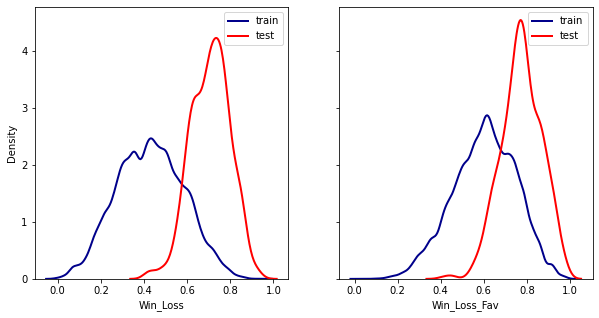

In [10]:
kde_plot('Win_Loss', train, test)

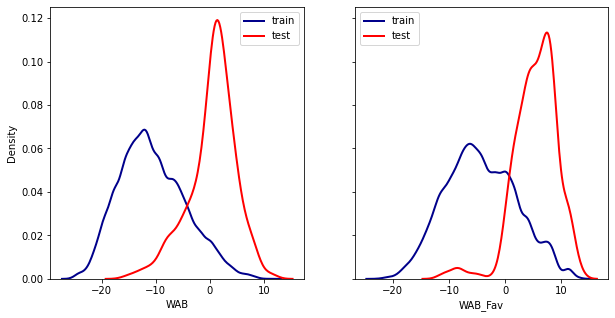

In [11]:
kde_plot('WAB', train, test)

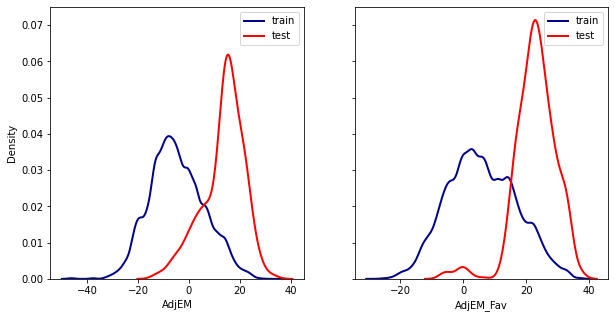

In [12]:
kde_plot('AdjEM', train, test)

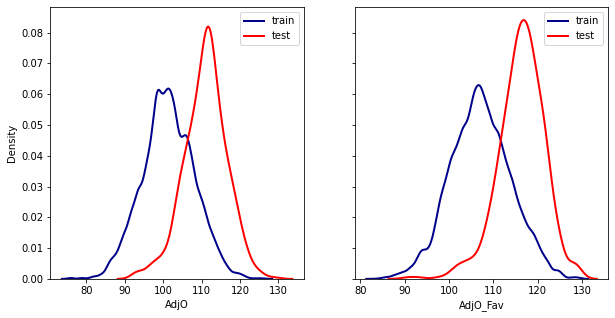

In [13]:
kde_plot('AdjO', train, test)

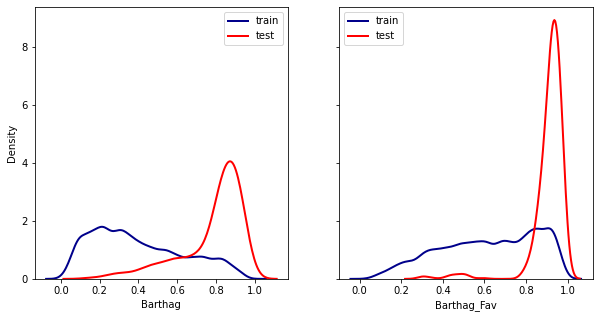

In [14]:
kde_plot('Barthag', train, test)

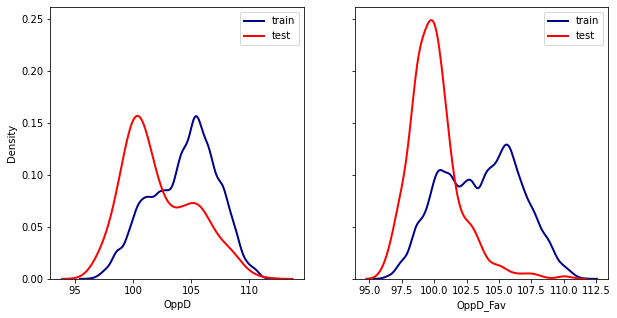

In [15]:
kde_plot('OppD', train, test)

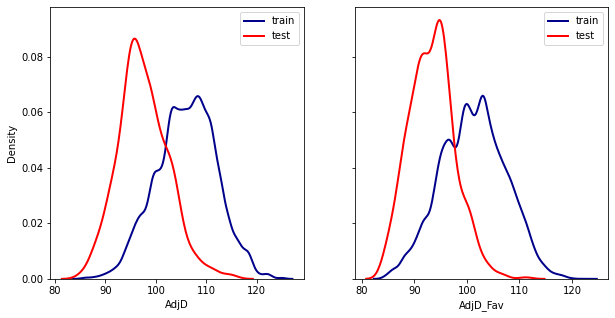

In [16]:
kde_plot('AdjD', train, test)

## Looking For Filtering Rules:

In the figures above, we can see that the NCAA Tournament data is more concentrated towards better values, while the regular season data is distributed over a larger range of values. We will next try and use the tournament data to help filter out data for games between teams that would likely not be able to make the NCAA Tournament.

To accomplish this goal, we'll examine different thresholds in the NCAA Tournament data, and then filter out games where that threshold is not met for a given feature. For example, say we are using the `Win_Loss` feature and the quantile $0.05$. We will find the 5$^{th}$ percentile of the `Win_Loss` feature in the NCAA Tournament data and filter out any game in the regular season data that has a `Win_Loss` value below that number. The hope is that by using combinations of features and thresholds, we can remove games from the regular season data that are between non-tournament quality teams and reduce the covariate shift between the two data sets.

In [17]:
# These appear to be the most important features
important_features = [
    'Win_Loss', 'WAB', 'AdjEM', 'Barthag'
]
important_features = important_features + [x + '_Fav' for x in important_features]

# Test all different combinations of features to use for rules
features_to_test = list()
for i in range(1, len(important_features)):
    features_to_test.extend([x for x in combinations(important_features, i)])
    
# Test using different cutoffs for each combination
quantiles =  [q / 100 for q in range(6)]

In [18]:
# Function to filter training data using the quantile value of the test data for the given features
def filter_train(features, quantile):
    thresholds = test.quantile(quantile)[features]
    is_above_threshold = pd.concat([train[feat] >= thresh for feat, thresh in thresholds.iteritems()], axis=1)
    return train[is_above_threshold.all(axis=1)]

In [19]:
# Start with initial values with no filtering
auc, f1 = cbb.covariate_shift(train, test)
tuning_df = pd.DataFrame({'Features': ['None'], 'Quantile': np.nan, 'auc': auc, 
                          'f1': f1, 'Size': len(train)})


# Test each combination of features/cutoffs
for features in features_to_test:
    for q in quantiles:
        if not isinstance(features, list):
            features = list(features)
        
        filtered = filter_train(features, q)
        auc, f1 = cov_shift(filtered, test)
        tuning_df = tuning_df.append({'Features': features, 'Quantile': q, 'auc': auc, 
                                      'f1': f1, 'Size': len(filtered)},
                                     ignore_index=True)

tuning_df.sort_values('auc').head()

,Features,Quantile,auc,f1,Size
749,"['Win_Loss', 'Win_Loss_Fav', 'WAB_Fav', 'Barth...",0.04,0.639811,0.651737,5054
1181,"['Win_Loss', 'Win_Loss_Fav', 'WAB_Fav', 'AdjEM...",0.04,0.641072,0.655564,4873
1368,"['Win_Loss', 'WAB', 'AdjEM', 'WAB_Fav', 'AdjEM...",0.05,0.642378,0.649520,4580
1349,"['Win_Loss', 'WAB', 'AdjEM', 'Win_Loss_Fav', '...",0.04,0.642421,0.659389,4835
1079,"['Win_Loss', 'WAB', 'Win_Loss_Fav', 'WAB_Fav',...",0.04,0.642867,0.652234,5008


In [20]:
tuning_df[tuning_df['auc'] < 0.70].sort_values('Size', ascending=False).head(15)

,Features,Quantile,auc,f1,Size
88,"['Win_Loss', 'Barthag_Fav']",0.03,0.694316,0.706034,6773
1096,"['Win_Loss', 'AdjEM', 'Barthag', 'Win_Loss_Fav...",0.03,0.687153,0.712721,6739
1000,"['Win_Loss', 'WAB', 'AdjEM', 'Win_Loss_Fav', '...",0.03,0.696556,0.713315,6737
1312,"['Win_Loss', 'WAB', 'AdjEM', 'Barthag', 'Win_L...",0.03,0.694663,0.713555,6712
280,"['Win_Loss', 'AdjEM', 'Barthag_Fav']",0.03,0.690944,0.700172,6683
664,"['Win_Loss', 'AdjEM', 'Barthag', 'Barthag_Fav']",0.03,0.691598,0.699843,6660
994,"['Win_Loss', 'WAB', 'AdjEM', 'Barthag', 'Barth...",0.03,0.680246,0.692425,6643
244,"['Win_Loss', 'WAB', 'AdjEM_Fav']",0.03,0.685617,0.693633,6472
340,"['Win_Loss', 'AdjEM_Fav', 'Barthag_Fav']",0.03,0.690967,0.696487,6434
298,"['Win_Loss', 'Barthag', 'AdjEM_Fav']",0.03,0.685134,0.697438,6417


In [21]:
tuning_df[tuning_df['Size'] > 12000].sort_values('auc').head(15)

,Features,Quantile,auc,f1,Size
4,['Win_Loss'],0.03,0.779238,0.801825,12132
69,"['Win_Loss', 'Win_Loss_Fav']",0.02,0.779481,0.801678,12113
591,"['Win_Loss', 'WAB', 'Barthag', 'WAB_Fav']",0.02,0.782800,0.806255,12458
255,"['Win_Loss', 'AdjEM', 'Barthag']",0.02,0.786442,0.809070,14050
237,"['Win_Loss', 'WAB', 'WAB_Fav']",0.02,0.787516,0.809464,12692
614,"['Win_Loss', 'WAB', 'Win_Loss_Fav', 'AdjEM_Fav']",0.01,0.787626,0.809873,14184
1419,"['Win_Loss', 'AdjEM', 'Barthag', 'WAB_Fav', 'A...",0.02,0.787721,0.811147,12141
981,"['Win_Loss', 'WAB', 'AdjEM', 'Barthag', 'WAB_F...",0.02,0.787765,0.809304,12372
687,"['Win_Loss', 'AdjEM', 'WAB_Fav', 'AdjEM_Fav']",0.02,0.788326,0.808519,12270
1478,"['Win_Loss', 'WAB', 'AdjEM', 'Barthag', 'Win_L...",0.01,0.789051,0.811012,13824


In [22]:
# Save data to csv since it takes some time to run
tuning_df.to_csv('../../Data/analysis/cov_shift.csv', index=False)

## Evaluating Rules

In the tables above, we can see different combinations of features, the quantile value used to find thresholds, the average AUC/F1 metrics after running the covariate shift analysis 5 times and the number of games that remained in filtered data set.

After looking through the values, I settled on two different rules: 
1) Using a threshold of the $2^{nd}$ percentile of the `Win_Loss`, `AdjEM`, and `Barthag` features
2) Using a threshold of the $3^{nd}$ percentile of the `Win_Loss`, `WAB`, and `AdjEM_Fav` features

In general, I liked rules that used the `Win_Loss` feature because it was both the most important for the covariate shift analysis and also because it is a pretty basic stat. I also liked to pair it with more advanced stats from different data sets (for example `AdjEM` and `Barthag` are from the Kenpom and T-Rank data sets respectively). 

The first rule I call the "Lenient" rule because it left more games unfiltered in the final data set (14,050 games) and the second rule is the "Strinct" rule because it left only 6,472 games after filtering. I also will include another rule in the comparison below: I filtered out all games that were not between two teams that ended up in the tournament. Hopefully, we can see how each of these data sets compare to the original regular season and NCAA tournament sets as well as to each other.

In [23]:
rules = [
    (['Win_Loss', 'AdjEM', 'Barthag'], 0.02), # Lenient Rule
    (['Win_Loss', 'WAB', 'AdjEM_Fav'], 0.03)  # Strict rule
]
filtered_dfs = [filter_train(f, q) for f, q in rules]

# Also we'll see what filtering by games where both teams were tournament teams
filtered_dfs.append(train[(train['Seed'].notna()) & (train['Seed_Fav'].notna())])

names = ['lenient', 'strict', 'seeded']

In [24]:
pd.DataFrame({
    'Name': names,
    'Features': [x[0] for x in rules] + [None],
    'Quantile': [x[1] for x in rules] + [None],
    'Size': [len(df) for df in filtered_dfs],
    'Cov Shift AUC': [cov_shift(df, test)[0] for df in filtered_dfs]
})

,Name,Features,Quantile,Size,Cov Shift AUC
0,lenient,"[Win_Loss, AdjEM, Barthag]",0.02,14050,0.832220
1,strict,"[Win_Loss, WAB, AdjEM_Fav]",0.03,6472,0.673160
2,seeded,None,NaN,2807,0.656539


In [25]:
# Create list of features to test
non_feature_cols = ['Favored', 'Underdog', 'Year', 'Label', 'Tournament',
                    'Seed', 'Seed_Fav', 'Seed_Diff']
feature_to_test = [f for f in df.columns if (f not in non_feature_cols 
                                             and '_Diff' not in f 
                                             and 'Rank' not in f and 'Rk' not in f)]

results = list()
for feature in feature_to_test:
    metrics = list()
    auc_full, f1_full = cov_shift(train[[feature]], test[[feature]])
    auc_lenient, f1_lenient = cov_shift(filtered_dfs[0][[feature]], test[[feature]])
    auc_strict, f1_strict = cov_shift(filtered_dfs[1][[feature]], test[[feature]])
    auc_seed, f1_seed = cov_shift(filtered_dfs[2][[feature]], test[[feature]])
    
    results.append((feature, auc_full, f1_full, auc_lenient, f1_lenient,
                    auc_strict, f1_strict, auc_seed, f1_seed))
    
# Save results in a dataframe and sort by MCC
cols = ['Feature', 'AUC (train)', 'F1 (train)', 'AUC (lenient)', 'F1 (lenient)',
        'AUC (strict)', 'F1 (strict)', 'AUC (seed)', 'F1 (seed)']
results_df = pd.DataFrame(results, columns=cols).sort_values('AUC (train)', ascending=False)
results_df.head(10)

,Feature,AUC (train),F1 (train),AUC (lenient),F1 (lenient),AUC (strict),F1 (strict),AUC (seed),F1 (seed)
1,Win_Loss,0.900596,0.906691,0.726097,0.743584,0.661011,0.678797,0.574401,0.522693
51,WAB,0.831222,0.840347,0.683103,0.711804,0.579256,0.599930,0.558376,0.538529
50,WAB_Fav,0.800762,0.816141,0.705677,0.733575,0.563540,0.566869,0.493186,0.474164
24,Barthag_Fav,0.788161,0.802184,0.676059,0.697702,0.520436,0.531681,0.467802,0.466860
2,AdjEM_Fav,0.781962,0.795641,0.657859,0.680698,0.493753,0.511337,0.463109,0.466062
25,Barthag,0.781792,0.797781,0.638472,0.653184,0.547504,0.555231,0.513729,0.519985
55,MP,0.778349,0.790836,0.622885,0.653056,0.567493,0.606117,0.539615,0.546549
3,AdjEM,0.773427,0.791066,0.656653,0.681968,0.547697,0.555864,0.531395,0.498843
7,AdjD,0.773107,0.784825,0.619305,0.614356,0.545401,0.546255,0.530476,0.524586
16,OppD_Fav,0.773097,0.794235,0.653081,0.694055,0.505604,0.499654,0.466167,0.447104


The table above shows the results of running the covariate shift analysis for just listed feature values  for each of the various data sets when compared to the NCAA tournament data. We can see how the "strict" and "seeded" data is very close to the tournament data gererally.

Next, we will look feature distributions for each of the original and filtered data sets.

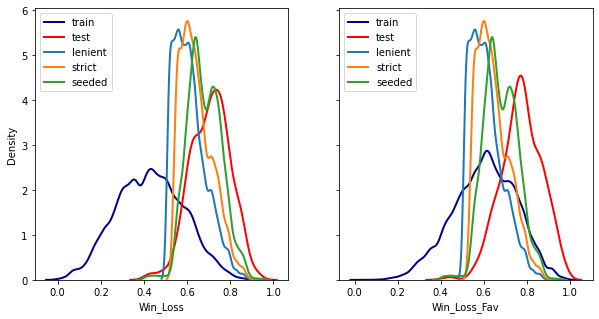

In [26]:
kde_plot('Win_Loss', train, test, filtered_dfs, names)

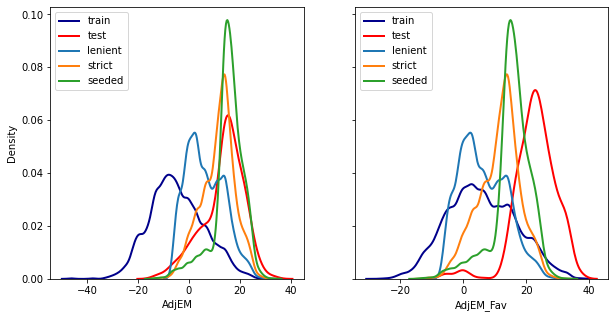

In [27]:
kde_plot('AdjEM', train, test, filtered_dfs, names)

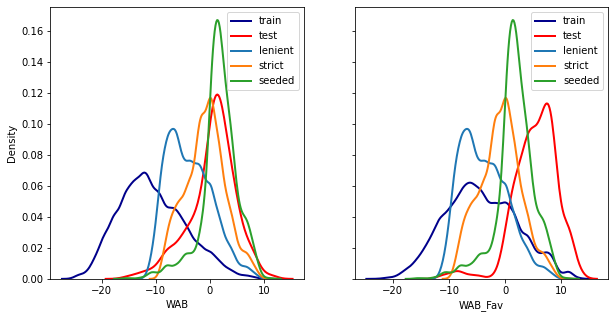

In [28]:
kde_plot('WAB', train, test, filtered_dfs, names)

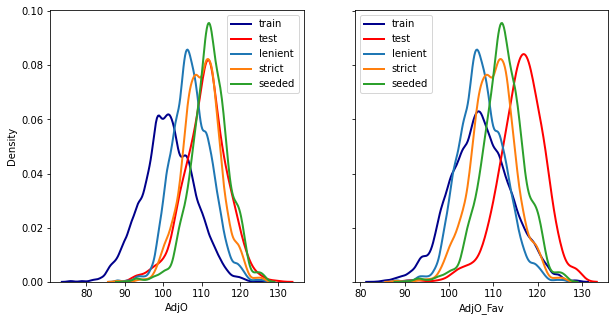

In [29]:
kde_plot('AdjO', train, test, filtered_dfs, names)

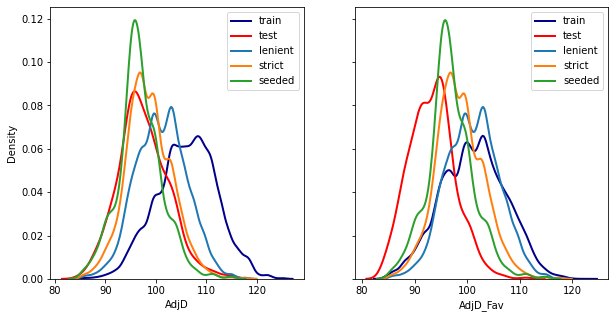

In [30]:
kde_plot('AdjD', train, test, filtered_dfs, names)

The above charts highlight some of the differences between each data set:

**"Lenient" Data:** This data seems to be about halfway between the regular season data and the NCAA Tournament data. This makes sense because we're only cutting out the games between obviously not tournament quality teams, but this still leaves us with a lot of "barely" tournament quality games because the regular season data was distributed around a much lower (or higher depending on the feaute) center for each feature. Overall, I think this data could be a good choice for training models moving forward because it reduces the difference between the regular season without removing too many games.

**"Strict" Data:** This set appears to most closely resemble the feature distributions of the NCAA Tournament data. It looks to be a pretty good representation of tournament data, but the issue here could be the limited number of games in the training set. This method filtered out the regular season data to less than half the size of the "lenient" data. 

**"Seeded" Data:** I included this data set as well since it seemed like an easy rule to limit games to tournament quality. I mean why not just look at games between Tournament teams right? While it seems like an obvious solution, we can see from the feature distributions above that this ends up concentrating the features even more than the tournament data. This makes sense because small conferences often only have one team make the tournament by winning the conference tournament. These teams often have lower season stats/ratings and they make up most of the lower seeds in the tournament. The regular season just doesn't feature enough games between these types of teams and teams from bigger conferences and we end up with just games between NCAA Tournament teams from large conferences that represent most of the higher seeds and we get the even more concentrated distributions shown above.

In [31]:
# Save each data set to csv
pd.concat([filtered_dfs[0], test]).to_csv('../../Data/Training/large_training.csv', index=False)
pd.concat([filtered_dfs[1], test]).to_csv('../../Data/Training/small_training.csv', index=False)